In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload
from typing import List, Dict, Tuple

import scipy.sparse
import scipy.sparse.linalg
from scipy.sparse import csr_matrix

import celeri

plt.rcParams["text.usetex"] = False # Plotting the global model is much much faster with tex fonts turned off

# Read in data files and do basic processing

In [3]:
# Japan example
# command_file_name = "../data/command/japan_command.json"

# Western North America example
command_file_name = "../data/command/western_north_america_command.json"

In [4]:
# command, segment, block, meshes, station, mogi, sar = celeri.read_data(command_file_name)
# celeri.create_output_folder(command)

command = celeri.get_command(command_file_name)
celeri.create_output_folder(command)
logger = celeri.get_logger(command)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)

station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command, meshes)
sar = celeri.process_sar(sar, command)
closure, block = celeri.assign_block_labels(segment, station, block, mogi, sar)
assembly = addict.Dict()
operators = addict.Dict()
operators.meshes = [addict.Dict()] * len(meshes)
assembly = celeri.merge_geodetic_data(assembly, station, sar) # Not sure this works correctly

2022-07-20 22:40:07.969 | INFO     | celeri.celeri:get_logger:108 - Read: ../data/command/japan_command.json
2022-07-20 22:40:07.970 | INFO     | celeri.celeri:get_logger:109 - RUN_NAME: 2022-07-20-22-40-07
2022-07-20 22:40:07.970 | INFO     | celeri.celeri:get_logger:110 - Write log file: ../runs/2022-07-20-22-40-07/2022-07-20-22-40-07.log
2022-07-20 22:40:07.971 | INFO     | celeri.celeri:read_data:115 - Reading data files
2022-07-20 22:40:07.974 | SUCCESS  | celeri.celeri:read_data:119 - Read: ../data/segment/japan_segment.csv
2022-07-20 22:40:07.977 | SUCCESS  | celeri.celeri:read_data:124 - Read: ../data/block/japan_block.csv
2022-07-20 22:40:07.977 | SUCCESS  | celeri.celeri:read_data:131 - Read: ../data/mesh/japan_mesh_parameters.json



Warning: The file contains tag data that couldn't be processed.

2022-07-20 22:40:08.004 | SUCCESS  | celeri.celeri:read_data:237 - Read: ../data/mesh/nankai.msh



Warning: The file contains tag data that couldn't be processed.

2022-07-20 22:40:08.040 | SUCCESS  | celeri.celeri:read_data:237 - Read: ../data/mesh/japan.msh



Warning: The file contains tag data that couldn't be processed.

2022-07-20 22:40:08.069 | SUCCESS  | celeri.celeri:read_data:237 - Read: ../data/mesh/sagami.msh
2022-07-20 22:40:08.072 | SUCCESS  | celeri.celeri:read_data:273 - Read: ../data/station/japan_station.csv
2022-07-20 22:40:08.074 | INFO     | celeri.celeri:read_data:288 - No mogi_file_name
2022-07-20 22:40:08.075 | INFO     | celeri.celeri:read_data:310 - No sar_file_name


In [5]:
sar

,lon,lat,depth,line_of_sight_change_val,line_of_sight_change_sig,look_vector_x,look_vector_y,look_vector_z,reference_point_x,reference_point_y,x,y,z,block_label


# Get elastic operators and TDE smoothing operators

In [6]:
# Get all elastic operators for segments and TDEs
celeri.get_elastic_operators(operators, meshes, segment, station, command)

# Get TDE smoothing operators
celeri.get_all_mesh_smoothing_matrices(meshes, operators)


2022-07-20 22:40:08.442 | INFO     | celeri.celeri:get_elastic_operators:1494 - Using precomputed elastic operators


# Calculate non-elastic operators

In [7]:
n_blocks = len(block)
operators.rotation_to_velocities = celeri.get_rotation_to_velocities_partials(station, n_blocks)
operators.global_float_block_rotation = celeri.get_global_float_block_rotation_partials(station)
assembly, operators.block_motion_constraints = celeri.get_block_motion_constraints(assembly, block, command)
assembly, operators.slip_rate_constraints = celeri.get_slip_rate_constraints(assembly, segment, block, command)
operators.rotation_to_slip_rate = celeri.get_rotation_to_slip_rate_partials(segment, block)
operators.block_strain_rate_to_velocities, strain_rate_block_index = celeri.get_block_strain_rate_to_velocities_partials(block, station, segment)
operators.mogi_to_velocities = celeri.get_mogi_to_velocities_partials(mogi, station, command)
celeri.get_tde_slip_rate_constraints(meshes, operators)

2022-07-20 22:40:09.183 | INFO     | celeri.celeri:get_slip_rate_constraints:1166 - No slip rate constraints


# Plot input data

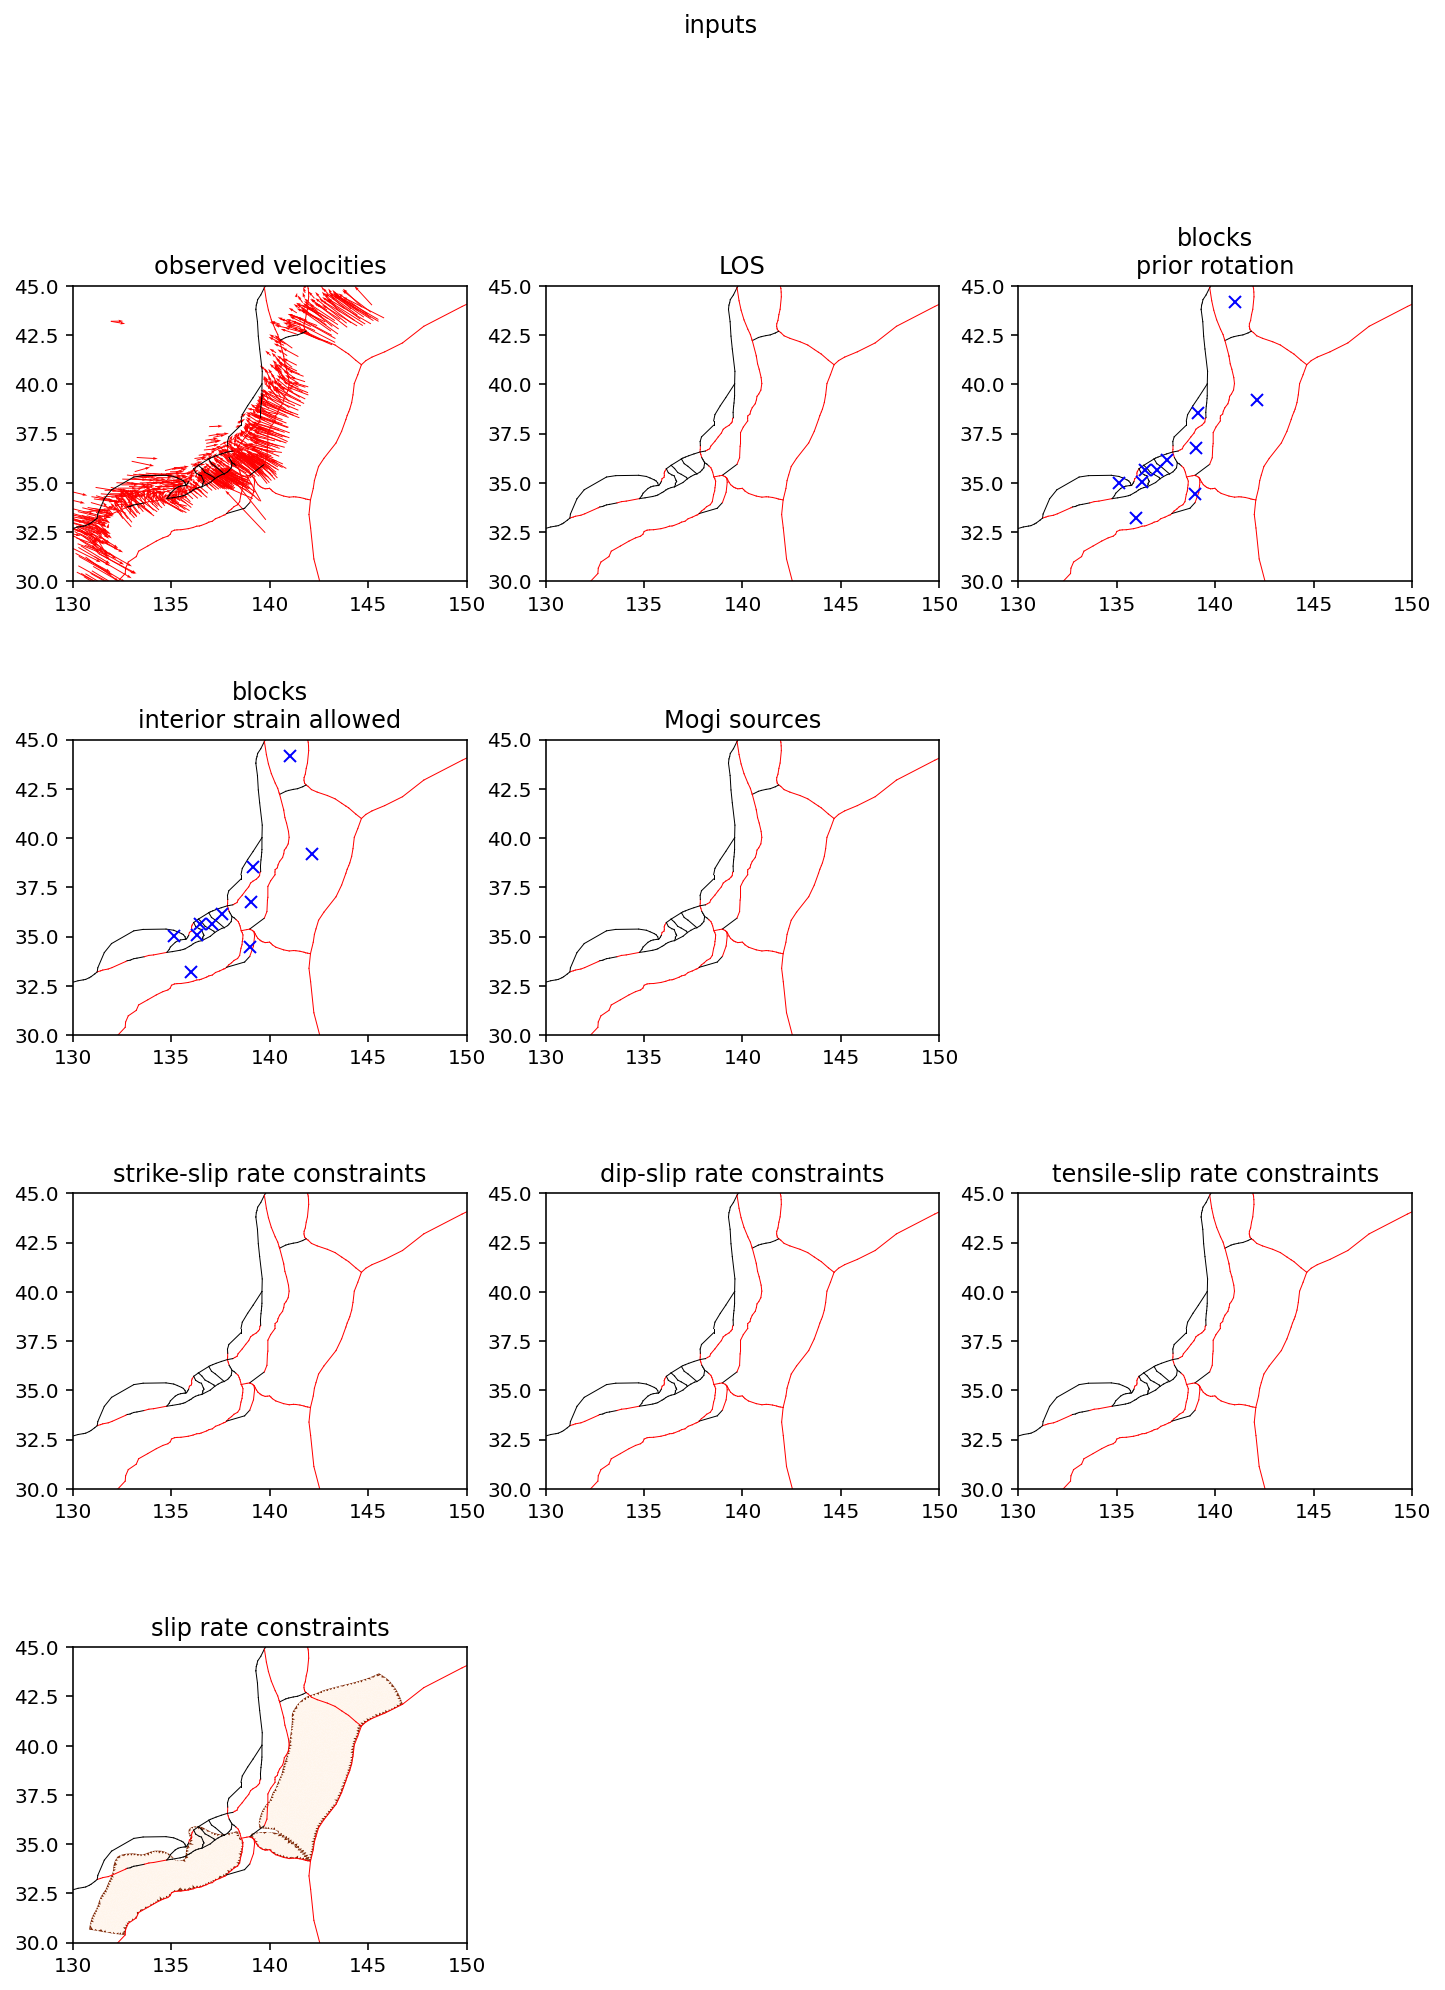

2022-07-20 22:40:11.643 | SUCCESS  | celeri.celeri:plot_input_summary:4017 - Wrote figures../runs/2022-07-20-22-40-07/plot_input_summary.(pdf, png)


<Figure size 432x288 with 0 Axes>

In [8]:
celeri.plot_input_summary(command, segment, station, block, meshes, mogi, sar, lon_range=command.lon_range, lat_range=command.lat_range, quiver_scale=command.quiver_scale)

# Estimate block model parameters (dense)

In [9]:
_, estimation = celeri.assemble_and_solve_dense(command, assembly, operators, station, block, meshes)
index = celeri.get_index(assembly, station, block, meshes)
celeri.post_process_estimation(estimation, operators, station, index)
# celeri.write_output(command, estimation, station, segment, block, meshes)

# Plot model summary

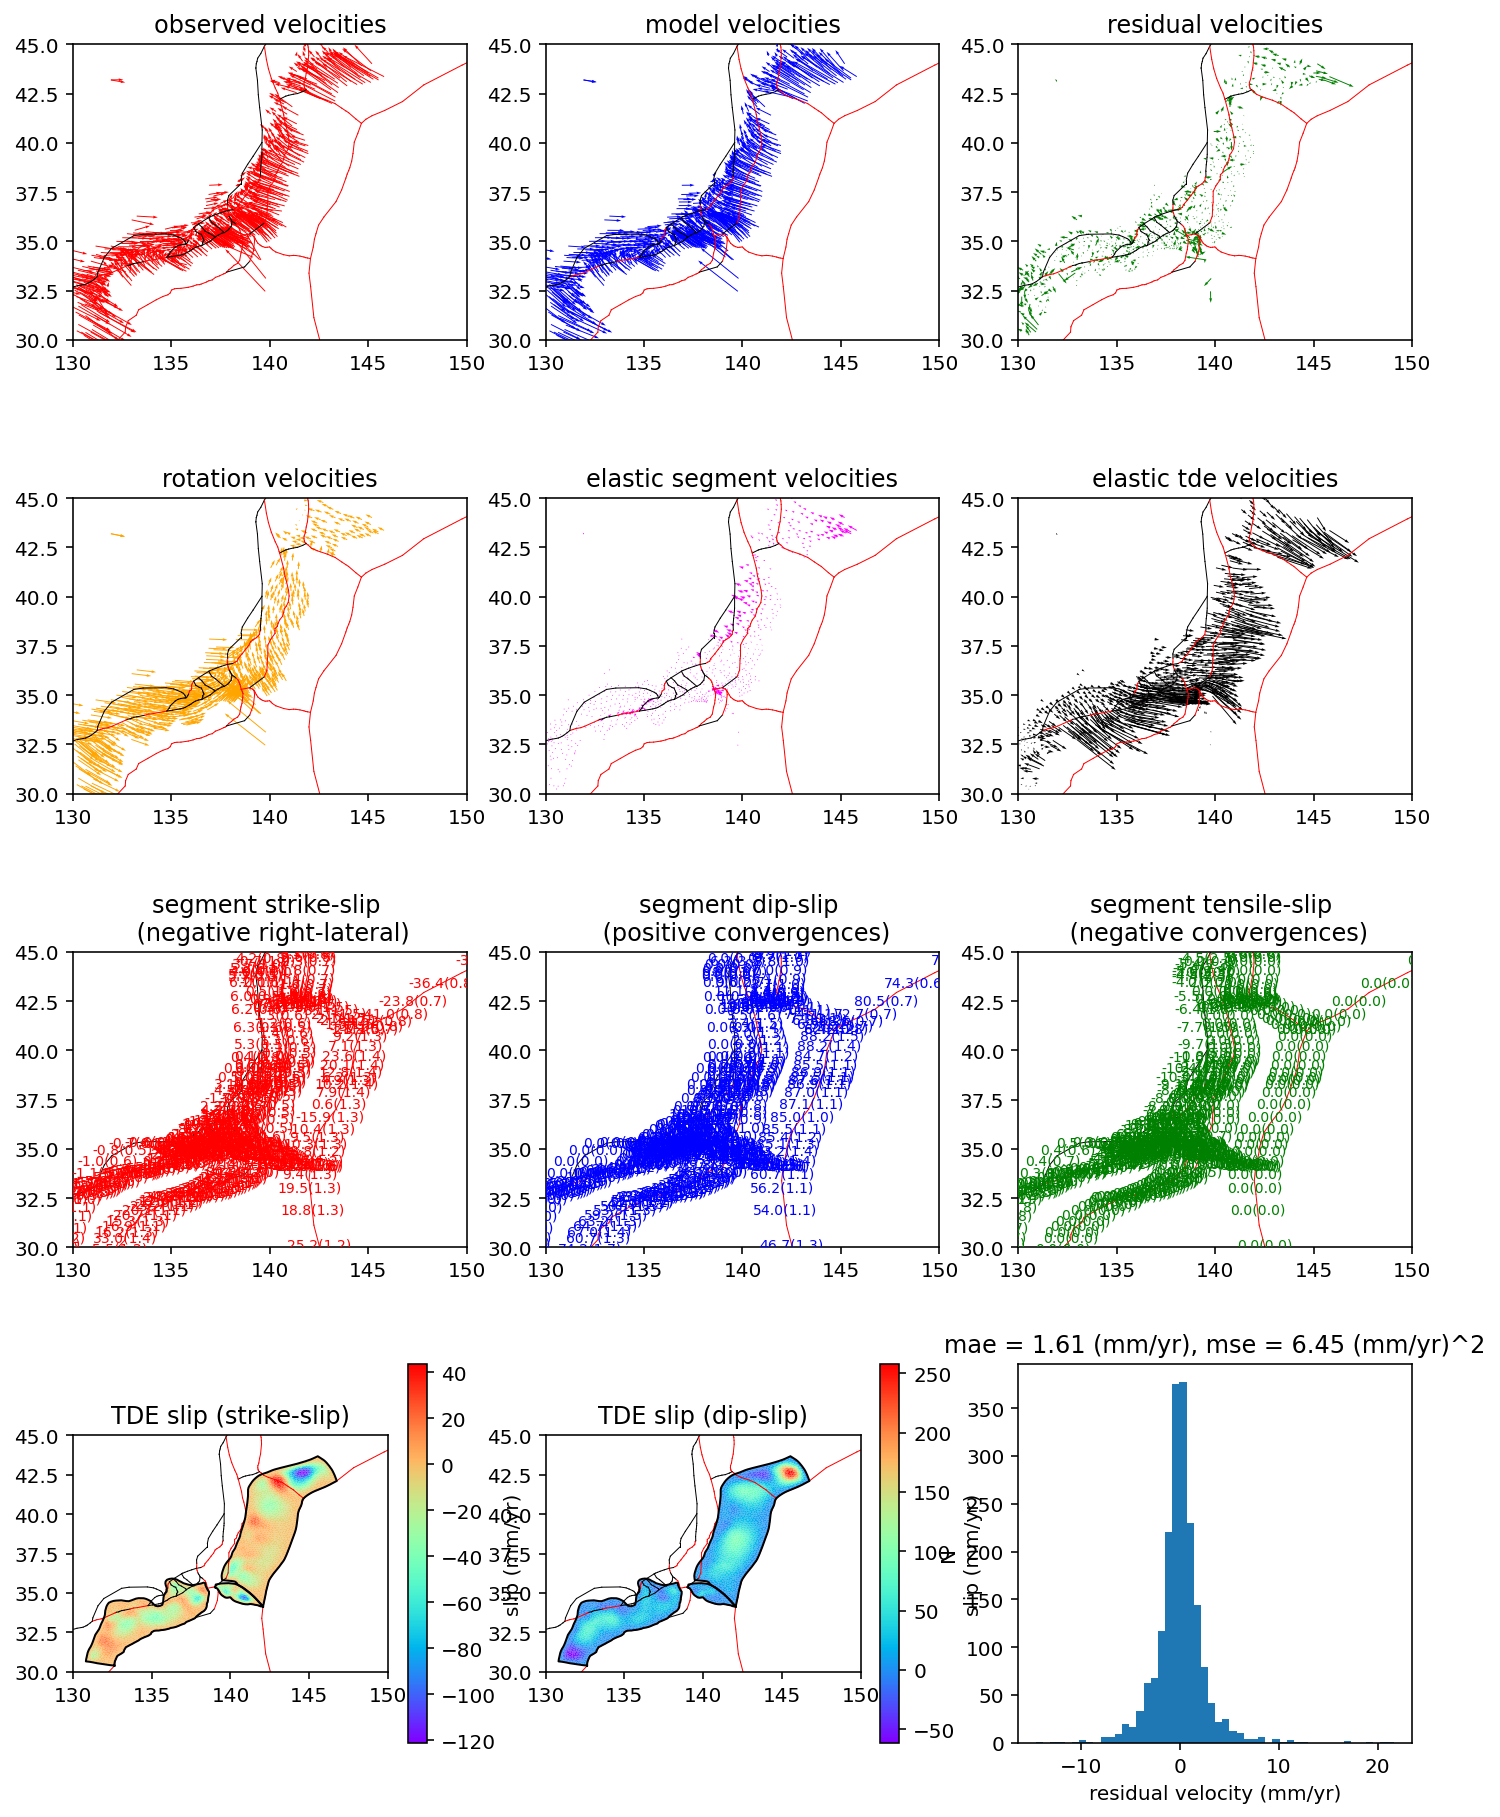

2022-07-20 22:40:42.621 | SUCCESS  | celeri.celeri:plot_estimation_summary:4517 - Wrote figures../runs/2022-07-20-22-40-07/plot_estimation_summary.(pdf, png)


<Figure size 432x288 with 0 Axes>

In [10]:
celeri.plot_estimation_summary(command, segment, station, meshes, estimation, lon_range=command.lon_range, lat_range=command.lat_range, quiver_scale=command.quiver_scale)

# Calculate col_norms and H for each mesh here.

In [11]:
# Data and data weighting vector
weighting_vector = celeri.get_weighting_vector(command, station, meshes, index)
data_vector = celeri.get_data_vector(assembly, index)

# Apply data weighting
data_vector = data_vector * np.sqrt(weighting_vector)

from celeri.hmatrix import build_hmatrix_from_mesh_tdes

# Cast all block submatrices to sparse
sparse_block_motion_okada_faults = csr_matrix(operators.rotation_to_velocities[index.station_row_keep_index, :] - operators.rotation_to_slip_rate_to_okada_to_velocities[index.station_row_keep_index, :])
sparse_block_motion_constraints = csr_matrix(operators.block_motion_constraints)
sparse_block_slip_rate_constraints = csr_matrix(operators.slip_rate_constraints)

# Calculate column normalization vector for blocks
operator_block_only = celeri.get_full_dense_operator_block_only(operators, index)
weighting_vector_block_only = weighting_vector[0:operator_block_only.shape[0]][:, None]
col_norms = np.linalg.norm(operator_block_only * np.sqrt(weighting_vector_block_only), axis=0)


# Create lists for all TDE matrices per mesh
H = []
for i in range(len(meshes)):
    # Get full TDE to velocity matrix for current mesh
    tde_to_velocities = celeri.get_elastic_operator_single_mesh(meshes, station, command, i)
    
    # H-matrix representation
    H.append(build_hmatrix_from_mesh_tdes(
        meshes[i],
        station,
        -tde_to_velocities,
        # 1e-4,
        1e-6,
        min_separation=1.25,
        min_pts_per_box=20,
    ))
    print(f"mesh {i} ({meshes[i].name}) H-matrix compression ratio: {H[i].report_compression_ratio():0.4f}")

    # Case smoothing matrices and tde slip rate constraints to sparse
    smoothing_keep_index = celeri.get_keep_index_12(operators.smoothing_matrix[i].shape[0])
    operators.smoothing_matrix[i] = csr_matrix(operators.smoothing_matrix[i][smoothing_keep_index, :][:, smoothing_keep_index])    
    operators.tde_slip_rate_constraints[i] = csr_matrix(operators.tde_slip_rate_constraints[i])

    # Eliminate unused columns and rows of TDE to velocity matrix
    tde_to_velocities = np.delete(tde_to_velocities, np.arange(2, tde_to_velocities.shape[0], 3), axis=0)
    tde_to_velocities = np.delete(tde_to_velocities, np.arange(2, tde_to_velocities.shape[1], 3), axis=1)

    # Calculate column normalization vector current TDE mesh
    weighting_vector_no_zero_rows = celeri.get_weighting_vector_single_mesh_for_col_norms(command, station, meshes, index, i)
    current_tde_mesh_columns_full_no_zero_rows = np.vstack((-tde_to_velocities, operators.smoothing_matrix[i].toarray(), operators.tde_slip_rate_constraints[i].toarray())) * np.sqrt(weighting_vector_no_zero_rows[:, None])

    # Concatenate everthing we need for col_norms
    col_norms_current_tde_mesh = np.linalg.norm(current_tde_mesh_columns_full_no_zero_rows, axis=0)
    col_norms = np.hstack((col_norms, col_norms_current_tde_mesh))
    print(col_norms.shape)


2022-07-20 22:40:42.746 | INFO     | celeri.celeri:get_elastic_operator_single_mesh:3277 - Using precomputed elastic operators
2022-07-20 22:40:42.778 | INFO     | celeri.celeri:get_elastic_operator_single_mesh:3304 - Saving elastic to velocity matrices to :../data/operators/japan_elastic_operators.hdf5
mesh 0 ({}) H-matrix compression ratio: 0.5898
(3867,)
2022-07-20 22:40:46.700 | INFO     | celeri.celeri:get_elastic_operator_single_mesh:3277 - Using precomputed elastic operators
2022-07-20 22:40:46.740 | INFO     | celeri.celeri:get_elastic_operator_single_mesh:3304 - Saving elastic to velocity matrices to :../data/operators/japan_elastic_operators.hdf5
mesh 1 ({}) H-matrix compression ratio: 0.4711
(9109,)
2022-07-20 22:40:52.307 | INFO     | celeri.celeri:get_elastic_operator_single_mesh:3277 - Using precomputed elastic operators
2022-07-20 22:40:52.311 | INFO     | celeri.celeri:get_elastic_operator_single_mesh:3304 - Saving elastic to velocity matrices to :../data/operators/japa

In [12]:
def matvec(v):
    """ Build matvec (matrix vector product) operator for 
    scipy.sparse.linalg.LinearOperator.  This returns A * u

    BJM: Should we be passing in: W, X, index, etc. or let them be known from the outer scope???
    TBT: This will depend on how we integrate this into celeri and which
    variable we're talking about. For example, we should stop using X.shape
    entirely because that matrix won't exist in a fully sparse/hmatrix
    implementation!
    One design that I would probably lean towards
    would be something like:
    def build_sparse_hmatrix_linear_operator(operators,...):
        sparse_block_motion_okada_faults = ...
        define_other_precomputable_vars_here = ...

        def matvec(v):
            # use vars from the outer scope
        def rmatvec(v):
            # use vars from the outer scope

        return scipy.sparse.linalg.LinearOperator(X.shape, matvec=matvec, rmatvec=rmatvec)
        
    Args:
        u (nd.array): Candidate state vector

    Returns:
        out (nd.array): Predicted data vector
    """

    # BJM: Weight the data vector
    # TBT: It's important to remember to keep the input and output weighting
    # conceptually separate since the "out * np.sqrt(W)" will actually change
    # the solution to the least squares problem whereas the "v / col_norms"
    # preconditioning step is a reversible change to the solution (which is the
    # point since preconditioning should not change the solution!!)
    v_scaled = v / col_norms 

    # Make storage for output
    # out = np.zeros(X.shape[0])
    out = np.zeros(index.n_operator_rows)
    block_rotations = v_scaled[index.start_block_col : index.end_block_col]

    # Okada
    out[index.start_station_row : index.end_station_row] += sparse_block_motion_okada_faults.dot(block_rotations)

    # Block motion constraints
    out[index.start_block_constraints_row : index.end_block_constraints_row] += sparse_block_motion_constraints.dot(block_rotations)

    # Slip rate constraints
    out[index.start_slip_rate_constraints_row:index.end_slip_rate_constraints_row] += sparse_block_slip_rate_constraints.dot(block_rotations)

    # Loop over TDE meshes
    # for i in range(len(meshes)):
    for i in range(len(meshes)):
        tde_velocities = v_scaled[index.start_tde_col[i] : index.end_tde_col[i]]

        # Insert TDE to velocity matrix
        out[index.start_station_row : index.end_station_row] += H[i].dot(tde_velocities)

        # TDE smoothing
        out[index.start_tde_smoothing_row[i] : index.end_tde_smoothing_row[i]] += operators.smoothing_matrix[i].dot(tde_velocities)

        # TDE slip rate constraints
        out[index.start_tde_constraint_row[i] : index.end_tde_constraint_row[i]] += operators.tde_slip_rate_constraints[i].dot(tde_velocities)

    # Weight!
    return out * np.sqrt(weighting_vector)

In [13]:
def rmatvec(u):
    """ Build rmatvec (matrix vector product) operator for 
    scipy.sparse.linalg.LinearOperator.  This returns:
    Returns A^H * v, where A^H is the conjugate transpose of A
    for a candidate state vector, u.  We do this because
    with the h-matrix approach we no longer have the full matrix
    so we can't take the transpose all at once.

    Args:
        u (nd.array): Candidate state vector

    Returns:
        out (nd.array): Predicted data vector
    """

    # Weight the data vector
    u_weighted = u * np.sqrt(weighting_vector)

    # Storage for output
    # out = np.zeros(X.shape[1])
    out = np.zeros(index.n_operator_cols)

    # Select subset of weighted data for the observed velocities
    station_rows = u_weighted[index.start_station_row : index.end_station_row]
    block_constraints = u_weighted[index.start_block_constraints_row : index.end_block_constraints_row]

    # Select subset of weighted data for the fault slip rate constraints
    slip_rate_constraints = u_weighted[index.start_slip_rate_constraints_row : index.end_slip_rate_constraints_row]

    # Okada and block rotation contribution to data vector
    out[index.start_block_col : index.end_block_col] += station_rows @ sparse_block_motion_okada_faults

    # Block motion constraints contribution to data vector
    out[index.start_block_col : index.end_block_col] += block_constraints @ sparse_block_motion_constraints

    # Fault slip rate constraints contribution to data vector
    out[index.start_block_col : index.end_block_col] += slip_rate_constraints @ sparse_block_slip_rate_constraints

    for i in range(len(meshes)):
        # Select subset of weighted data for the TDE smoothing
        tde_smoothing = u_weighted[index.start_tde_smoothing_row[i] : index.end_tde_smoothing_row[i]]

        # Select subset of weighted data for the TDE slip rate constraints
        tde_slip_rate = u_weighted[index.start_tde_constraint_row[i] : index.end_tde_constraint_row[i]]

        # Hmatrix (TDEs to velocities)
        out[index.start_tde_col[i] : index.end_tde_col[i]] += H[i].transpose_dot(station_rows)

        # TDE smoothing contribution to data vector
        out[index.start_tde_col[i] : index.end_tde_col[i]] += tde_smoothing @ operators.smoothing_matrix[i]

        # TDE slip rate constraint contributions to data vector
        out[index.start_tde_col[i] : index.end_tde_col[i]] += tde_slip_rate @ operators.tde_slip_rate_constraints[i]

    # Weight
    return out / col_norms

In [14]:
# Instantiate the scipy the linear operator for the iterative solver to use
operator_hmatrix = scipy.sparse.linalg.LinearOperator((index.n_operator_rows, index.n_operator_cols), matvec=matvec, rmatvec=rmatvec)

# Solve the linear system
sparse_hmatrix_solution = scipy.sparse.linalg.lsqr(operator_hmatrix, data_vector, atol=command.atol, btol=command.btol, calc_var=True)

# Correct the solution for the col_norms preconditioning.
sparse_hmatrix_state_vector = sparse_hmatrix_solution[0] / col_norms


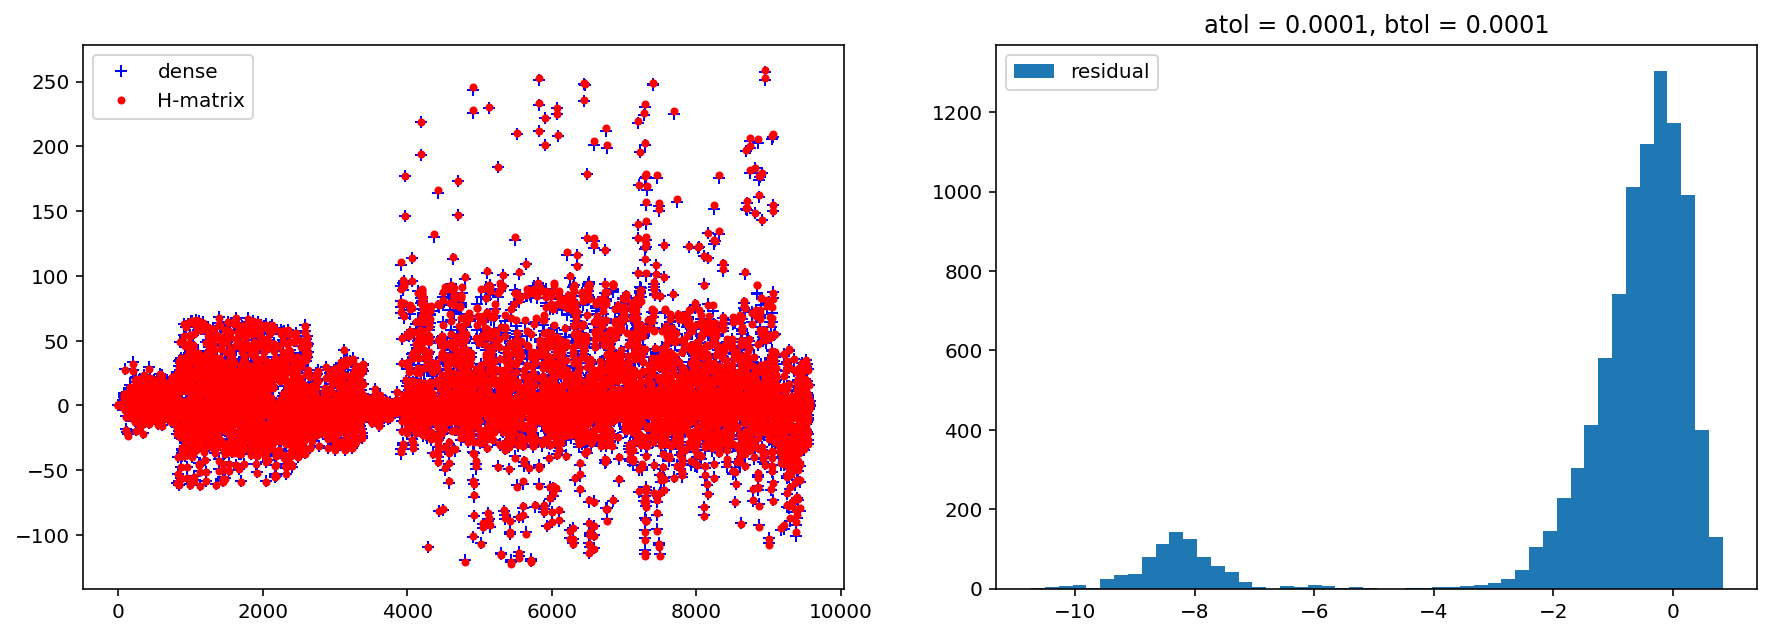

In [15]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(estimation.state_vector, "+b", label="dense")
plt.plot(sparse_hmatrix_state_vector, "r.", label="H-matrix")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(np.log10(np.abs(estimation.state_vector - sparse_hmatrix_state_vector)), 50, label="residual")
plt.title(f"atol = {command.atol}, btol = {command.btol}")
plt.legend()

plt.show()

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


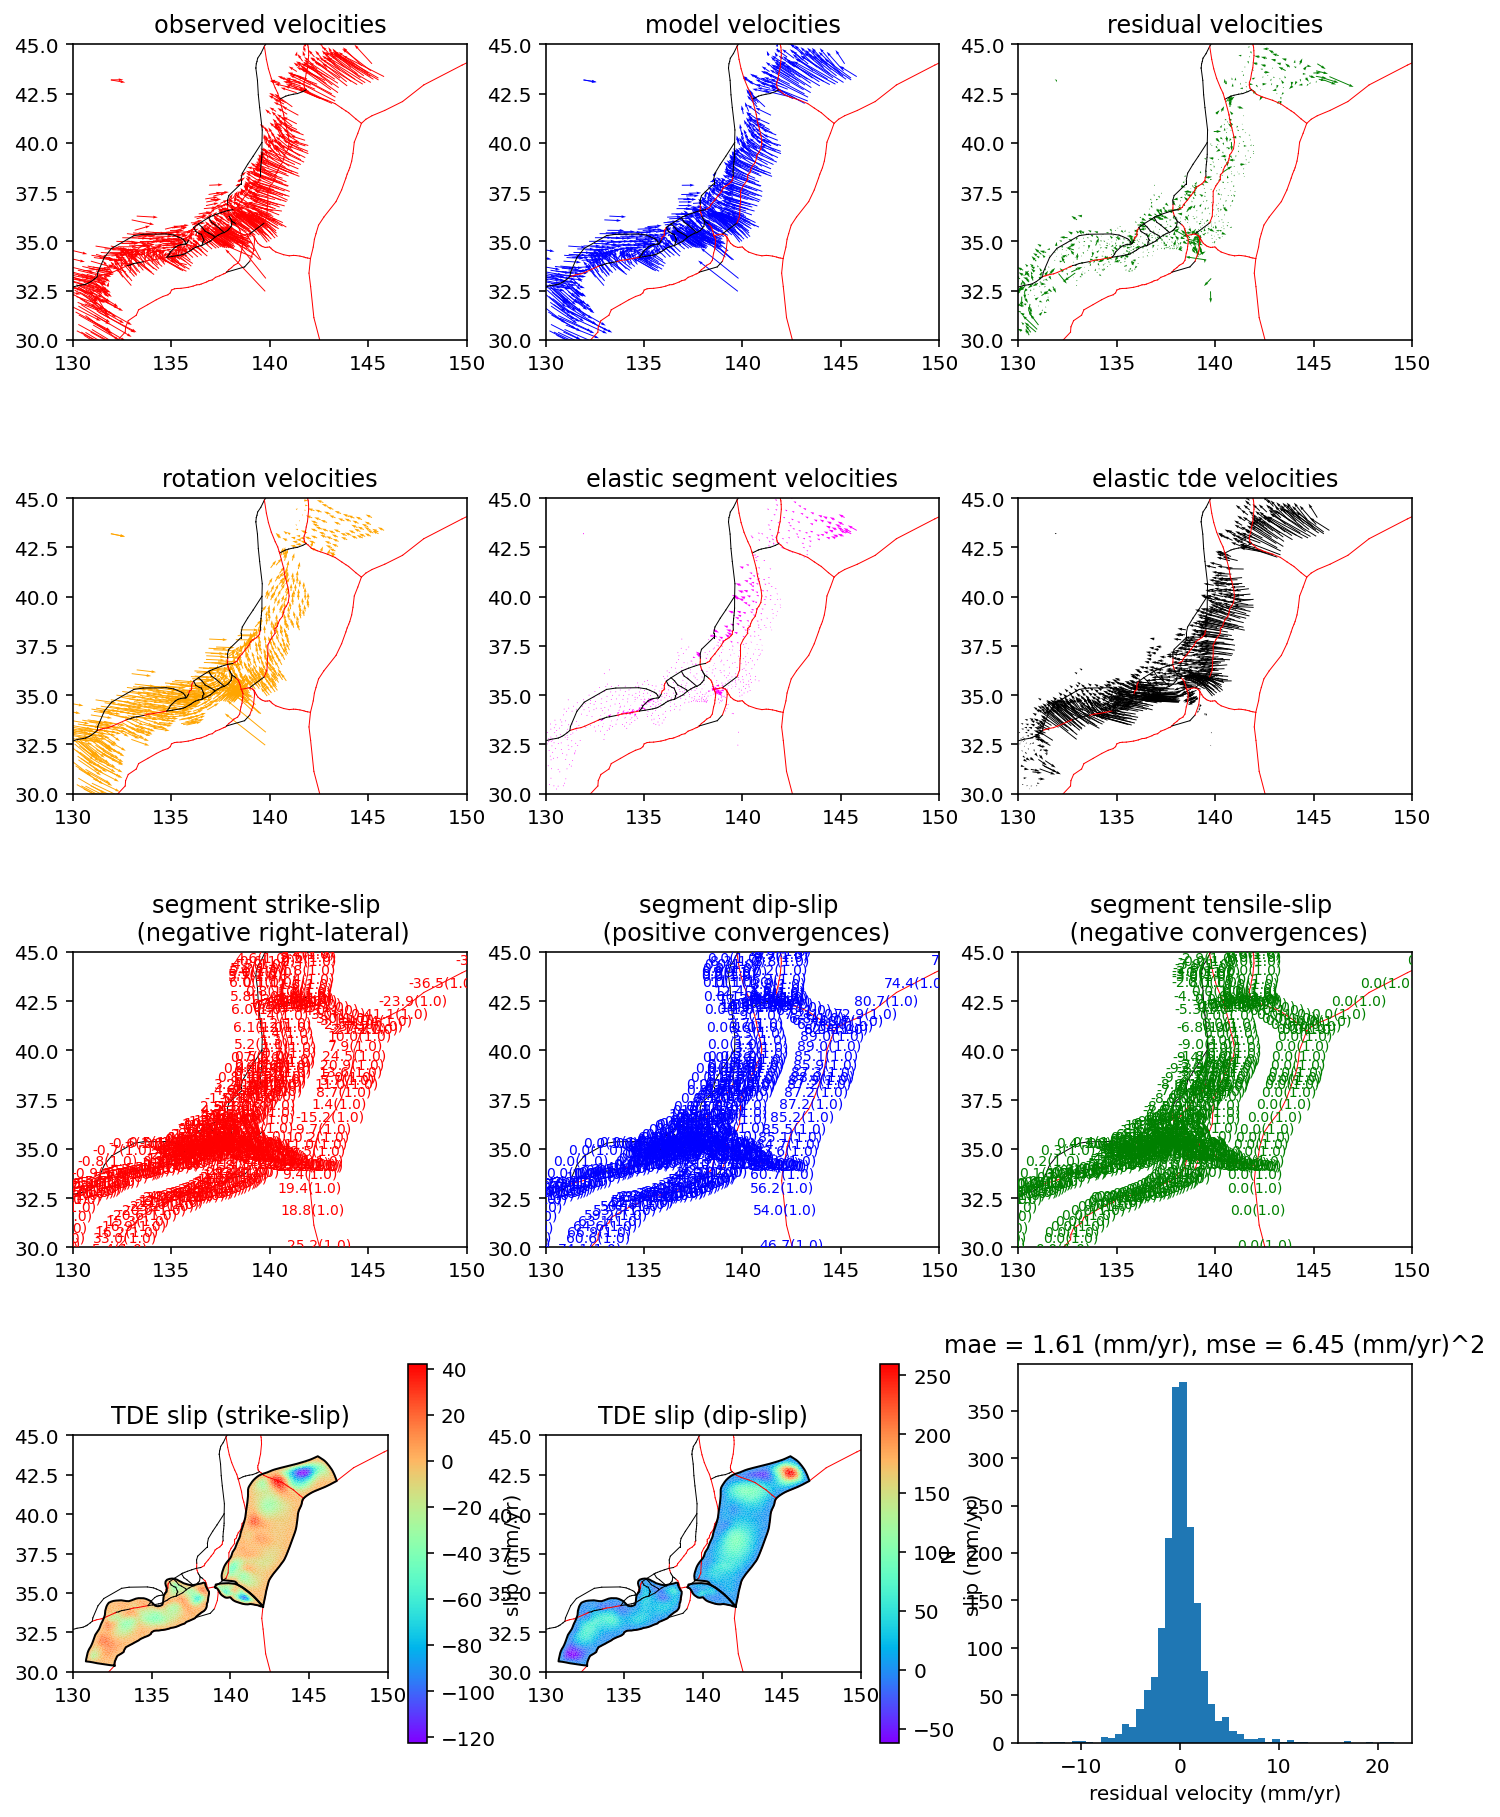

2022-07-20 22:41:27.775 | SUCCESS  | celeri.celeri:plot_estimation_summary:4517 - Wrote figures../runs/2022-07-20-22-40-07/plot_estimation_summary.(pdf, png)


<Figure size 432x288 with 0 Axes>

In [16]:
def post_process_estimation_hmatrix(
    estimation_hmatrix: Dict, operators: Dict, station: pd.DataFrame, index: Dict
):
    """Calculate derived values derived from the block model linear estimate (e.g., velocities, undertainties)

    Args:
        estimation (Dict): Estimated state vector and model covariance
        operators (Dict): All linear operators
        station (pd.DataFrame): GPS station data
        index (Dict): Indices and counts of data and array sizes
    """

    # estimation_hmatrix.state_vector = estimation_hmatrix.state_vector
    # estimation_hmatrix.predictions = estimation_hmatrix.operator @ (estimation_hmatrix.state_vector * col_norms)
    estimation_hmatrix.predictions = matvec(estimation_hmatrix.state_vector * col_norms) / np.sqrt(weighting_vector)
    # estimation_hmatrix.predictions = estimation_hmatrix.operator @ (estimation_hmatrix.state_vector)

    estimation_hmatrix.vel = estimation_hmatrix.predictions[0 : 2 * index.n_stations]
    estimation_hmatrix.east_vel = estimation_hmatrix.vel[0::2]
    estimation_hmatrix.north_vel = estimation_hmatrix.vel[1::2]

    # Calculate mean squared residual velocity
    estimation_hmatrix.east_vel_residual = estimation_hmatrix.east_vel - station.east_vel
    estimation_hmatrix.north_vel_residual = estimation_hmatrix.north_vel - station.north_vel

    # Extract TDE slip rates from state vector
    estimation_hmatrix.tde_rates = estimation_hmatrix.state_vector[
        3 * index.n_blocks : 3 * index.n_blocks + 2 * index.n_tde_total
    ]
    estimation_hmatrix.tde_strike_slip_rates = estimation_hmatrix.tde_rates[0::2]
    estimation_hmatrix.tde_dip_slip_rates = estimation_hmatrix.tde_rates[1::2]

    # Extract segment slip rates from state vector
    estimation_hmatrix.slip_rates = (
        operators.rotation_to_slip_rate
        @ estimation_hmatrix.state_vector[0 : 3 * index.n_blocks]
    )
    estimation_hmatrix.strike_slip_rates = estimation_hmatrix.slip_rates[0::3]
    estimation_hmatrix.dip_slip_rates = estimation_hmatrix.slip_rates[1::3]
    estimation_hmatrix.tensile_slip_rates = estimation_hmatrix.slip_rates[2::3]

    estimation_hmatrix.strike_slip_rate_sigma = np.ones_like(estimation_hmatrix.strike_slip_rates)
    estimation_hmatrix.dip_slip_rate_sigma = np.ones_like(estimation_hmatrix.dip_slip_rates)
    estimation_hmatrix.tensile_slip_rate_sigma = np.ones_like(estimation_hmatrix.tensile_slip_rates)

    # Calculate rotation only velocities
    # TODO: Check if this is still the name for the sparse version
    print(type(operators.rotation_to_velocities))
    estimation_hmatrix.vel_rotation = (
        operators.rotation_to_velocities[index.station_row_keep_index, :]
        @ estimation_hmatrix.state_vector[0 : 3 * index.n_blocks]
    )
    estimation_hmatrix.east_vel_rotation = estimation_hmatrix.vel_rotation[0::2]
    estimation_hmatrix.north_vel_rotation = estimation_hmatrix.vel_rotation[1::2]

    # Calculate fully locked segment velocities
    print(type(operators.rotation_to_slip_rate_to_okada_to_velocities))
    estimation_hmatrix.vel_elastic_segment = (
        operators.rotation_to_slip_rate_to_okada_to_velocities[
            index.station_row_keep_index, :
        ]
        @ estimation_hmatrix.state_vector[0 : 3 * index.n_blocks]
    )
    estimation_hmatrix.east_vel_elastic_segment = estimation_hmatrix.vel_elastic_segment[0::2]
    estimation_hmatrix.north_vel_elastic_segment = estimation_hmatrix.vel_elastic_segment[1::2]

    # TODO: Calculate block strain rate velocities
    estimation_hmatrix.east_vel_block_strain_rate = np.zeros(len(station))
    estimation_hmatrix.north_vel_block_strain_rate = np.zeros(len(station))

    # Calculate TDE velocities    
    estimation_hmatrix.vel_tde = np.zeros(2 * index.n_stations)
    # for i in range(len(operators.tde_to_velocities)):
    for i in range(len(meshes)):
    
        estimation_hmatrix.vel_tde += (
            H[i].dot(estimation.state_vector[index.start_tde_col[i] : index.end_tde_col[i]])
        )
    estimation_hmatrix.east_vel_tde = estimation_hmatrix.vel_tde[0::2]
    estimation_hmatrix.north_vel_tde = estimation_hmatrix.vel_tde[1::2]


# import copy
# estimation_hmatrix = copy.deepcopy(estimation)

# dict_keys(['data_vector', 'weighting_vector', 'operator', 'state_covariance_matrix', 'state_vector'])
estimation_hmatrix = addict.Dict()
estimation_hmatrix.data_vector = data_vector
estimation_hmatrix.weighting_vector = weighting_vector
estimation_hmatrix.operator = operator_hmatrix
estimation_hmatrix.state_vector = sparse_hmatrix_state_vector
post_process_estimation_hmatrix(estimation_hmatrix, operators, station, index)
celeri.plot_estimation_summary(command, segment, station, meshes, estimation_hmatrix, lon_range=command.lon_range, lat_range=command.lat_range, quiver_scale=command.quiver_scale)


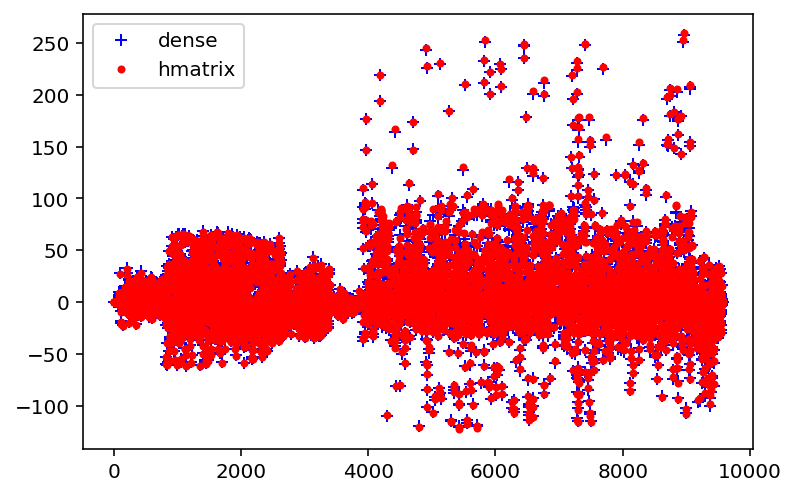

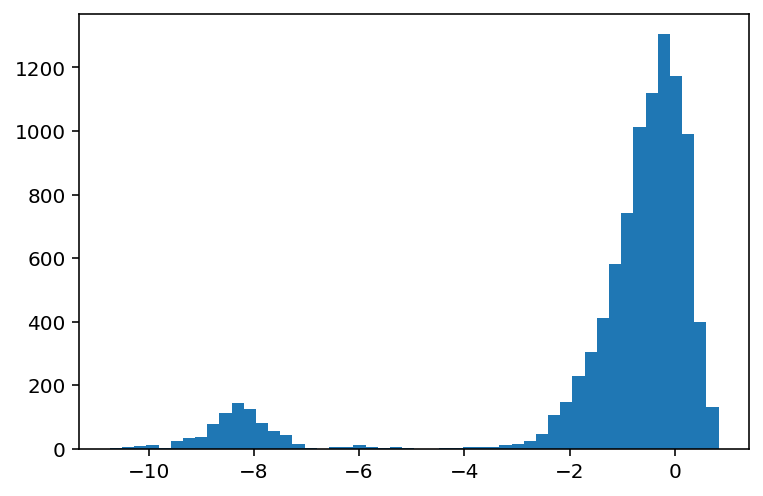

In [17]:
plt.figure()
plt.plot(estimation.state_vector, "+b", label="dense")
plt.plot(estimation_hmatrix.state_vector, ".r", label="hmatrix")
plt.legend()
plt.show()


plt.figure()
plt.hist(np.log10(np.abs(estimation_hmatrix.state_vector - estimation.state_vector)), 50)
plt.show()

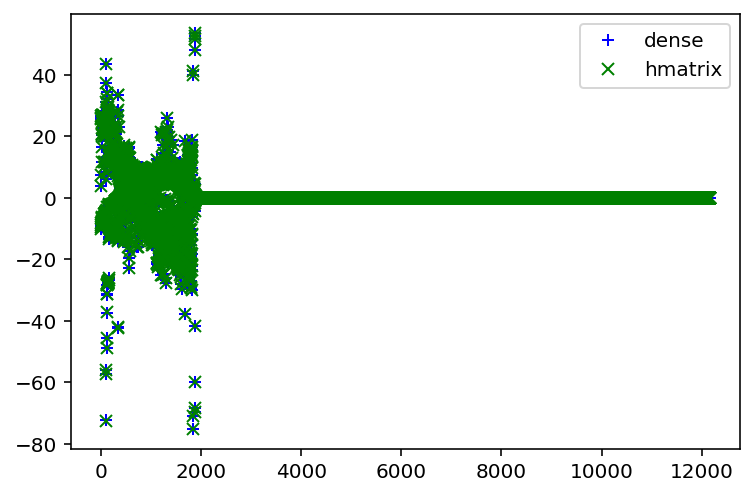

In [18]:
plt.figure()
plt.plot(estimation.operator @ estimation.state_vector, "+b", label="dense")
# plt.plot((estimation_hmatrix.operator @ estimation_hmatrix.state_vector) / np.sqrt(weighting_vector), ".r", label="hmatrix", alpha=0.1)
plt.plot((matvec(estimation_hmatrix.state_vector * col_norms) / np.sqrt(weighting_vector)), "xg", label="hmatrix")

plt.legend()
plt.show()

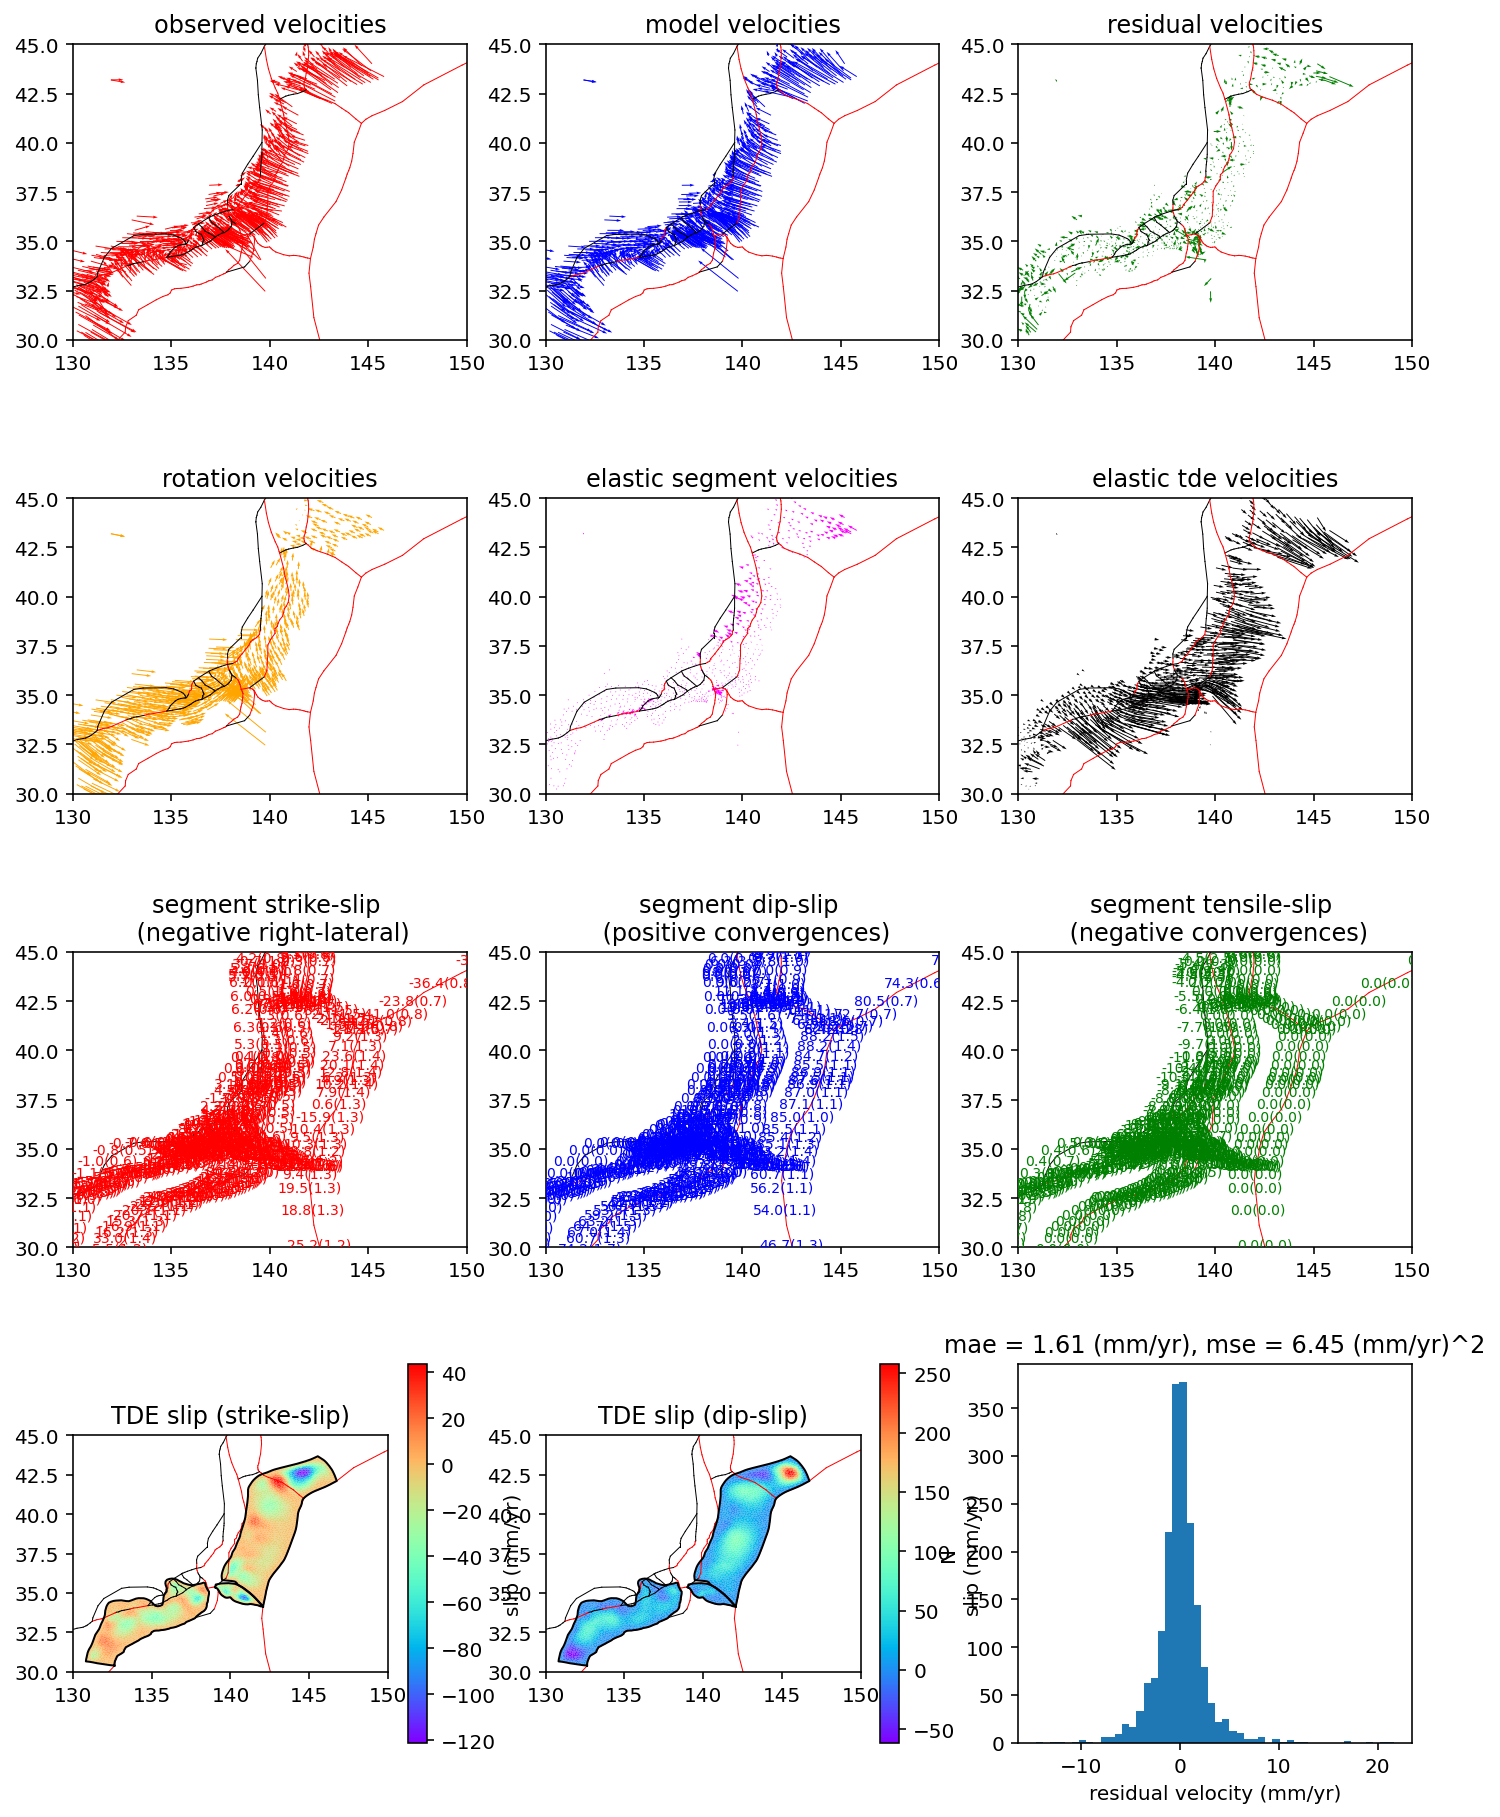

2022-07-20 22:41:32.556 | SUCCESS  | celeri.celeri:plot_estimation_summary:4517 - Wrote figures../runs/2022-07-20-22-40-07/plot_estimation_summary.(pdf, png)


<Figure size 432x288 with 0 Axes>

In [19]:
# estimation.state_vector = sparse_hmatrix_state_vector
celeri.post_process_estimation(estimation, operators, station, index)
celeri.plot_estimation_summary(command, segment, station, meshes, estimation, lon_range=command.lon_range, lat_range=command.lat_range, quiver_scale=command.quiver_scale)

# Uncertainy estimates

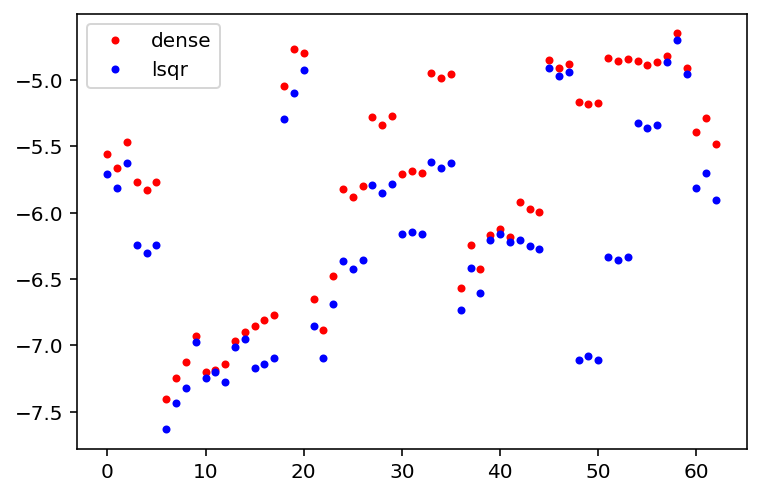

In [20]:
import copy
dense_sigma = np.diag(copy.deepcopy(estimation.state_covariance_matrix))
dense_sigma = np.sqrt(dense_sigma)
sparse_sigma = np.sqrt(sparse_hmatrix_solution[9]) / col_norms
plt.figure()
plt.plot(np.log10(dense_sigma[0:3*len(block)]), ".r", label="dense")
plt.plot(np.log10(sparse_sigma[0:3*len(block)]), ".b", label="lsqr")
plt.legend()
plt.show()

# Compare hmatrix and dense

In [21]:
# matvec(estimation_hmatrix.state_vector * col_norms, h_matrix_solve_parameters) / np.sqrt(estimation_hmatrix.weighting_vector)

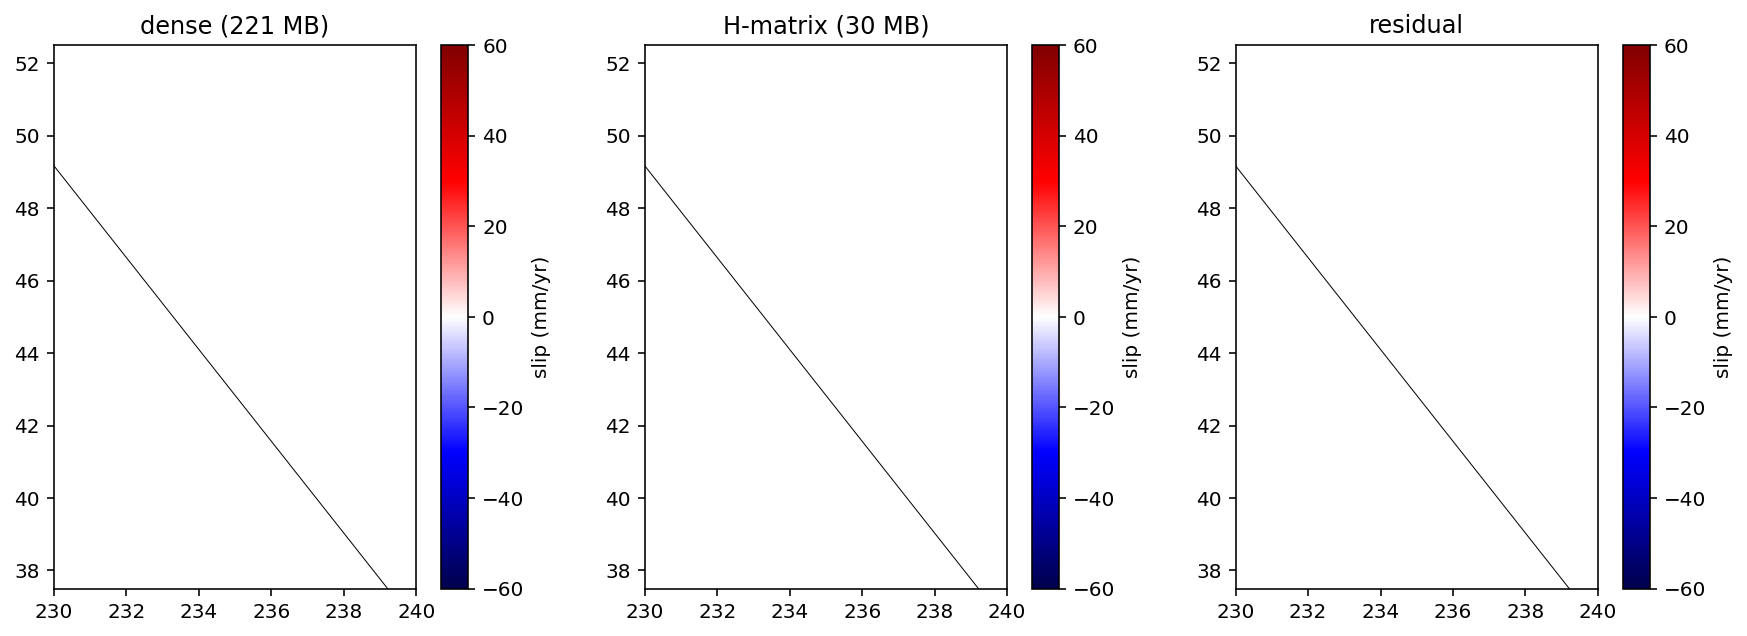

In [22]:
def common_plot_elements(segment: pd.DataFrame, lon_range: Tuple, lat_range: Tuple):
    """Elements common to all subplots

    Args:
        segment (pd.DataFrame): Fault segments
        lon_range (Tuple): Longitude range (min, max)
        lat_range (Tuple): Latitude range (min, max)
    """
    for i in range(len(segment)):
        if segment.dip[i] == 90.0:
            plt.plot(
                [segment.lon1[i], segment.lon2[i]],
                [segment.lat1[i], segment.lat2[i]],
                "-k",
                linewidth=0.5,
            )
        else:
            plt.plot(
                [segment.lon1[i], segment.lon2[i]],
                [segment.lat1[i], segment.lat2[i]],
                "-r",
                linewidth=0.5,
            )

    plt.xlim([lon_range[0], lon_range[1]])
    plt.ylim([lat_range[0], lat_range[1]])
    plt.gca().set_aspect("equal", adjustable="box")


import matplotlib.collections
lon_range = (230, 240)
lat_range = (37.5, 52.5)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
common_plot_elements(segment, lon_range, lat_range)
fill_value = estimation.tde_dip_slip_rates
# fill_value_range = [np.min(fill_value), np.max(fill_value)]
fill_value_range = [-60, 60]

ax = plt.gca()
for i in range(len(meshes)):
    x_coords = meshes[i].meshio_object.points[:, 0]
    y_coords = meshes[i].meshio_object.points[:, 1]
    vertex_array = np.asarray(meshes[i].verts)

    xy = np.c_[x_coords, y_coords]
    verts = xy[vertex_array]
    pc = matplotlib.collections.PolyCollection(
        verts, edgecolor="none", cmap="seismic"
    )
    if i == 0:
        tde_slip_component_start = 0
        tde_slip_component_end = meshes[i].n_tde
    else:
        tde_slip_component_start = tde_slip_component_end
        tde_slip_component_end = tde_slip_component_start + meshes[i].n_tde
    pc.set_array(
        fill_value[tde_slip_component_start:tde_slip_component_end]
    )
    pc.set_clim(fill_value_range)
    ax.add_collection(pc)
    if i == len(meshes) - 1:
        plt.colorbar(pc, label="slip (mm/yr)")

    # Add mesh edge
    x_edge = x_coords[meshes[i].ordered_edge_nodes[:, 0]]
    y_edge = y_coords[meshes[i].ordered_edge_nodes[:, 0]]
    x_edge = np.append(x_edge, x_coords[meshes[0].ordered_edge_nodes[0, 0]])
    y_edge = np.append(y_edge, y_coords[meshes[0].ordered_edge_nodes[0, 0]])
    plt.plot(x_edge, y_edge, color="black", linewidth=3)
    plt.title("dense (221 MB)")

plt.subplot(1, 3, 2)
common_plot_elements(segment, lon_range, lat_range)
fill_value = estimation_hmatrix.tde_dip_slip_rates
# fill_value_range = [np.min(fill_value), np.max(fill_value)]
fill_value_range = [-60, 60]

ax = plt.gca()
for i in range(len(meshes)):
    x_coords = meshes[i].meshio_object.points[:, 0]
    y_coords = meshes[i].meshio_object.points[:, 1]
    vertex_array = np.asarray(meshes[i].verts)

    xy = np.c_[x_coords, y_coords]
    verts = xy[vertex_array]
    pc = matplotlib.collections.PolyCollection(
        verts, edgecolor="none", cmap="seismic"
    )
    if i == 0:
        tde_slip_component_start = 0
        tde_slip_component_end = meshes[i].n_tde
    else:
        tde_slip_component_start = tde_slip_component_end
        tde_slip_component_end = tde_slip_component_start + meshes[i].n_tde
    pc.set_array(
        fill_value[tde_slip_component_start:tde_slip_component_end]
    )
    pc.set_clim(fill_value_range)
    ax.add_collection(pc)
    if i == len(meshes) - 1:
        plt.colorbar(pc, label="slip (mm/yr)")

    # Add mesh edge
    x_edge = x_coords[meshes[i].ordered_edge_nodes[:, 0]]
    y_edge = y_coords[meshes[i].ordered_edge_nodes[:, 0]]
    x_edge = np.append(x_edge, x_coords[meshes[0].ordered_edge_nodes[0, 0]])
    y_edge = np.append(y_edge, y_coords[meshes[0].ordered_edge_nodes[0, 0]])
    plt.plot(x_edge, y_edge, color="black", linewidth=3)
    plt.title("H-matrix (30 MB)")

plt.subplot(1, 3, 3)
common_plot_elements(segment, lon_range, lat_range)
fill_value = estimation.tde_dip_slip_rates - estimation_hmatrix.tde_dip_slip_rates
fill_value_range = [-60, 60]
ax = plt.gca()
for i in range(len(meshes)):
    x_coords = meshes[i].meshio_object.points[:, 0]
    y_coords = meshes[i].meshio_object.points[:, 1]
    vertex_array = np.asarray(meshes[i].verts)

    xy = np.c_[x_coords, y_coords]
    verts = xy[vertex_array]
    pc = matplotlib.collections.PolyCollection(
        verts, edgecolor="none", cmap="seismic"
    )
    if i == 0:
        tde_slip_component_start = 0
        tde_slip_component_end = meshes[i].n_tde
    else:
        tde_slip_component_start = tde_slip_component_end
        tde_slip_component_end = tde_slip_component_start + meshes[i].n_tde
    pc.set_array(
        fill_value[tde_slip_component_start:tde_slip_component_end]
    )
    pc.set_clim(fill_value_range)
    ax.add_collection(pc)
    if i == len(meshes) - 1:
        plt.colorbar(pc, label="slip (mm/yr)")

    # Add mesh edge
    x_edge = x_coords[meshes[i].ordered_edge_nodes[:, 0]]
    y_edge = y_coords[meshes[i].ordered_edge_nodes[:, 0]]
    x_edge = np.append(x_edge, x_coords[meshes[0].ordered_edge_nodes[0, 0]])
    y_edge = np.append(y_edge, y_coords[meshes[0].ordered_edge_nodes[0, 0]])
    plt.plot(x_edge, y_edge, color="black", linewidth=3)
    plt.title("residual")


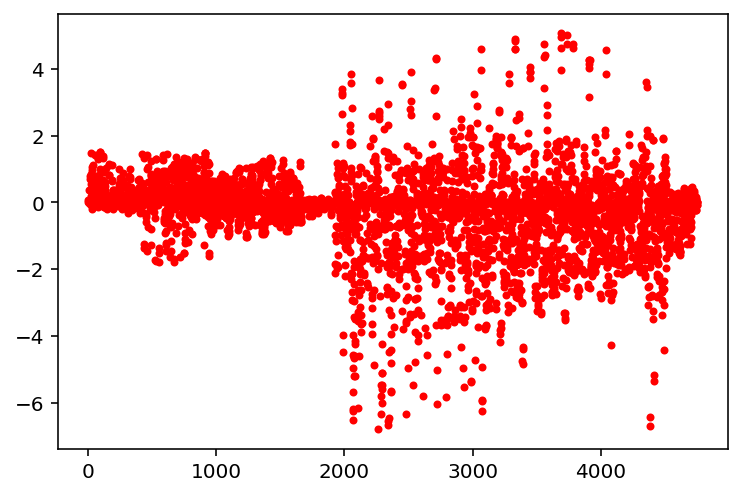

In [23]:
plt.plot(fill_value, ".r")

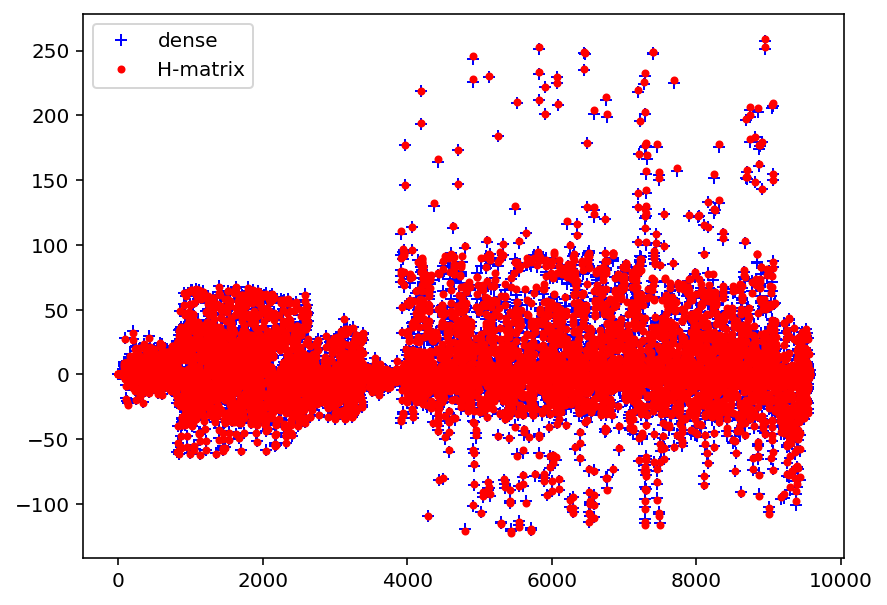

In [24]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(estimation.state_vector, "+b", label="dense")
plt.plot(sparse_hmatrix_state_vector, "r.", label="H-matrix")
plt.legend()

In [25]:
a = estimation.operator.size * estimation.operator.itemsize

In [28]:
print(a)

931373152
